# Drift correction

...for GPS tracks collected on drifting sea ice.

### needed:
- a mobile GPS track with X and Y (long, lat) coordinate pairs which needs drift removed
- a reference GPS track which contains the drift to be removed (eg from a fixed-to-floe GPS)

### basic strategy:
1. collect a common time window between the reference and mobile GPS track
2. choose a projected coordinate system expressed in meters, and reproject both GPS tracks to it
3. if one track has a higher time resolution, interpolate the other track so that both tracks have the same time resolution
4. subtract the reference track positions from the mobile track positions

### caveat:

This strategy assumes the ice floe has not rotated significantly during the survey.

In [1]:
## import all the libraries

# standard stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# reprojection help
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

# xml help for GPX files
import xml.etree.ElementTree as et

# cartopy, basemap is deprecated

In [2]:
## functions we make ourselves go here

## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-0.5
    end = np.max(t2)+0.5
    idx = (t1>=start)*(t1<=end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

# sometimes we can get lucky and get proj to find a UTM code for us
def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

# convert from lat lon to UTM
def makeutm(lon,lat,utmcode):
    
    thetransform = pyproj.transformer.Transformer.from_proj(4326,utmcode)
    gnssutm=thetransform.transform(lat, lon)
    east = gnssutm[0]
    north = gnssutm[1]
    
    return east, north

def readbasegps(filename):
    if 'gpx' in filename:
        # do xml parsing
        tree = et.parse(filename)
        print(filename)
        root = tree.getroot()
        trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
        trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
        trkpts = []
        for trkseg in trksegs:
            trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
        lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
        lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
        thetimes = [datetime.strptime(trkpt.find('{http://www.topografix.com/GPX/1/1}time').text,'%Y-%m-%dT%H:%M:%SZ')  for trkpt in trkpts]
        
        start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
        #start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')
        
        stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
        lon_pts = lon_pts[:stop_idx]
        lat_pts = lat_pts[:stop_idx]
        times = thetimes[:stop_idx]
        
    else:
        # assume POS CVS file, read with Pandas
        gnsstrack = pd.read_csv(filename,
                       skiprows=18)
        
        thetimes = gnsstrack[gnsstrack.keys()[0]].values
        print(thetimes[0:4])
        lat_pts = gnsstrack[" latitude(deg)"].values
        lon_pts = gnsstrack["longitude(deg)"].values
        # remove any leading or trailing spaces from the time string using strip,
        # drop precision to milliseconds (6 decimal places) by removing the last 0
        # then convert it to a datetime object
        times = [datetime.strptime(thistime.strip()[0:-1], "%Y/%m/%d %H:%M:%S.%f") for thistime in thetimes]
    
    #return lists of lon, lat and time, we do reprojection in its own function later
    return lon_pts, lat_pts, times

In [62]:
posfile = "/mnt/documents/Q1/P5-12032021/GPSdata/tracker1_ST/Current.gpx"

In [63]:
plon, plat, ptimes = readbasegps(posfile)

/mnt/documents/Q1/P5-12032021/GPSdata/tracker1_ST/Current.gpx


In [64]:
ptimes[0]

datetime.datetime(2021, 3, 12, 13, 42, 32)

In [65]:
plat[0]

80.4998176731

In [66]:
plon[0]

34.1077760886

In [67]:
ptimes[-1]

datetime.datetime(2021, 3, 12, 15, 45, 24)

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to UTM (or other projected system measured in meters)

In [68]:
## get the UTM zone
utmzone=getutm(plon[0], plat[0])
utmzone

[CRSInfo(auth_name='EPSG', code='32636', name='WGS 84 / UTM zone 36N', type=<PJType.PROJECTED_CRS: 'PROJECTED_CRS'>, deprecated=False, area_of_use=AreaOfUse(west=30.0, south=0.0, east=36.0, north=84.0, name='Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Turkey. Uganda. Ukraine.'), projection_method_name='Transverse Mercator')]


'32636'

In [69]:
## set up the proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,3413)

In [91]:
gnssutm = thetransform.transform(plat, plon)

## Convert time to seconds-of-day

**check time zones! Use UTC.**

In [71]:
gnssdayseconds=[]
for thetime in ptimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))

In [72]:
gnssdayseconds[0:5]

[49352.0, 49354.0, 49355.0, 49356.0, 49357.0]

## Load  GEM2 data to be drift corrected

In [73]:
gem2inputfile = "/mnt/documents/Q1/P5-12032021/GEM2/Q1-P5-transect-12032021-gem2-531-channel-thickness.csv"

In [74]:
gem2data = pd.read_csv(gem2inputfile)

In [75]:
gem2data

time   record_id   longitude   latitude   xc  \
0      2021-03-12T13:56:57.546875           0         0.0        0.0  0.0   
1      2021-03-12T13:56:57.640625           1         0.0        0.0  0.0   
2      2021-03-12T13:56:57.750000           2         0.0        0.0  0.0   
3      2021-03-12T13:56:57.843750           3         0.0        0.0  0.0   
4      2021-03-12T13:56:57.953125           4         0.0        0.0  0.0   
...                           ...         ...         ...        ...  ...   
27623  2021-03-12T15:11:58.218750       27623         0.0        0.0  0.0   
27624  2021-03-12T15:11:58.312500       27624         0.0        0.0  0.0   
27625  2021-03-12T15:11:58.406250       27625         0.0        0.0  0.0   
27626  2021-03-12T15:11:58.515625       27626         0.0        0.0  0.0   
27627  2021-03-12T15:11:58.609375       27627         0.0        0.0  0.0   

        yc  f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0      0.0           nan          0.853           0.803           0.883   
1      0.0           nan          0.813           0.834           0.870   
2      0.0           nan          0.847           0.809           0.883   
3      0.0           nan          0.970           0.835           0.895   
4      0.0           nan          0.858           0.854           0.880   
...    ...           ...            ...             ...             ...   
27623  0.0           nan          0.965           0.832           0.892   
27624  0.0           nan          0.948           0.813           0.886   
27625  0.0           nan          0.874           0.767           0.887   
27626  0.0           nan          0.860           0.751           0.902   
27627  0.0           nan          0.911           0.783           0.902   

        f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
0               0.876           0.872            0.884            0.873   
1               0.869           0.872            0.884            0.872   
2               0.878           0.877            0.885            0.877   
3               0.876           0.880            0.886            0.880   
4               0.870           0.875            0.885            0.878   
...               ...             ...              ...              ...   
27623           0.878           0.883            0.892            0.886   
27624           0.880           0.883            0.889            0.886   
27625           0.883           0.886            0.888            0.885   
27626           0.882           0.885            0.888            0.883   
27627           0.875           0.883            0.888            0.883   

        f63030Hz_hcp_i  f63030Hz_hcp_q  
0                0.898             nan  
1                0.898             nan  
2                0.898             nan  
3                0.897             nan  
4                0.898             nan  
...                ...             ...  
27623            0.906             nan  
27624            0.906             nan  
27625            0.904             nan  
27626            0.903             nan  
27627            0.905             nan  

[27628 rows x 16 columns]

In [76]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [77]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [78]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [79]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

In [80]:
gem2easting[0]

1013258.1739350952

In [81]:
plt.scatter(gem2easting-np.min(gem2easting), gem2northing-min(gem2northing), c = f1530hz_hcp_i)
plt.title("uncorrected drift track - local coordinates")

Text(0.5, 1.0, 'uncorrected drift track - local coordinates')

In [82]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [83]:
gem2dayseconds = np.round(gem2dayseconds, 4)

In [84]:
gem2dayseconds = np.array(gem2dayseconds)

In [124]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)


In [125]:
gnss_trimmedtime.size

4501

In [128]:
gnssutm = np.array(gnssutm)

In [129]:
gnssutm[0][gnss_trimmedtime]

array([[1013250.19027051, 1013250.74721869, 1013251.33935461, ...,
        1015020.3626883 , 1015020.72644587, 1015021.03492841]])

In [130]:
gnssdayseconds = np.array(gnssdayseconds)

In [131]:
gnssdayseconds

array([49352., 49354., 49355., ..., 56722., 56723., 56724.])

In [132]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [133]:
trimmedtime.size

4501

In [134]:
timesteps = np.arange(trimmedtime.min(), trimmedtime.max(), 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [135]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

CPU times: user 14min 16s, sys: 1min 53s, total: 16min 10s
Wall time: 16min 10s


In [136]:
len(timeindexes)

27360

In [137]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

In [138]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [139]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

In [140]:
local_gem2_east.size

27360

In [141]:
world_gem2_east = local_gem2_east + gnss_gem2_match_eastings[0]
world_gem2_north = local_gem2_north + gnss_gem2_match_northings[0]

In [142]:
world_gem2_east.size

27360

In [143]:
gnss_gem2_match_eastings[0]

1013250.4426237317

In [144]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i)

In [146]:
gem2_header = """AeN Q1 2021 P5 GEM2 measurements
GEM2-531 electromagnetic induction sounder
12 March 2021
Adam Steer / Dmitry Divine
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730

"""

In [147]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [148]:
gem2out = gem2data.copy()

In [149]:
gem2data.keys()

Index(['time', ' record_id', ' longitude', ' latitude', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [150]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

Index(['time', ' record_id', ' xc', ' yc', ' f450Hz_hcp_i', ' f450Hz_hcp_q',
       ' f1530Hz_hcp_i', ' f1530Hz_hcp_q', ' f5310Hz_hcp_i', ' f5310Hz_hcp_q',
       ' f18330Hz_hcp_i', ' f18330Hz_hcp_q', ' f63030Hz_hcp_i',
       ' f63030Hz_hcp_q'],
      dtype='object')

In [151]:
gem2out.insert(2, "easting", world_gem2_east)

In [152]:
gem2out.insert(3, "northing", world_gem2_north)

In [153]:
gem2out.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [154]:
gem2_output = "/mnt/documents/Q1/P5-12032021/GEM2/GEM2data-driftcorrected.csv"

In [155]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [156]:
gem2out.to_csv(gem2_output, index=False, mode='a')

## Load Magnaprobe data to be drift corrected

Using the old NP magnaprobe, 1024 weeks need to be added to the timestamp. This is because the internal GPS processing software doesn't know about the GPS week rollover in 2019 - so it is 1024 weeks out of sync, and has been since April 6 2019.

In [157]:
magnaprobeinputfile = "/mnt/documents/Q1/P5-12032021/magnaprobe/rawdata/NPI37.dat"


In [158]:
mpcolumns = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts","latitude_a","latitude_b","Longitude_a","Longitude_b","fix_quality","nmbr_satellites","HDOP","altitudeB","DepthVolts","LatitudeDDDDD","LongitudeDDDDD","month","dayofmonth","hourofday","minutes","seconds","microseconds"]

In [159]:
mpdata = pd.read_csv(magnaprobeinputfile, skiprows=4, names = mpcolumns)

In [160]:
mpdepths = mpdata["DepthCm"].values / 100
mprawtimes = mpdata["TIMESTAMP"].values
mprawtimes = mprawtimes
mprawtimes[0].split(' ')
mprawdays = [thistime.split(' ')[0] for thistime in mprawtimes]
mptimes = [thistime.split(' ')[1] for thistime in mprawtimes]
mpdays = [datetime.strptime(thisday, "%Y-%m-%d") for thisday in mprawdays]
mptimes = np.array(mptimes)

In [161]:
weekdelta = timedelta(weeks=1024)

In [162]:
mpdaysfixed = [day + weekdelta for day in mpdays]

In [163]:
mp_dayseconds=[]
for thetime in mptimes:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    mp_dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [164]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, mp_dayseconds)

In [165]:
gnssdayseconds = np.array(gnssdayseconds)

In [166]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [167]:
timesteps = np.arange(trimmedtime.min(), trimmedtime.max(), 0.01)
timesteps = np.round(timesteps, 2)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [168]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in mp_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

CPU times: user 326 ms, sys: 293 µs, total: 326 ms
Wall time: 325 ms


In [169]:
gnss_mp_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_mp_match_northings = np.squeeze(interp_north[timeindexes])

Now get geo-data from the magnaprobe organised

In [170]:
mplatddd = mpdata["latitude_a"].values + (mpdata["latitude_b"].values / 60)
mplonddd = mpdata["Longitude_a"].values + (mpdata["Longitude_b"].values / 60)

In [171]:
mputm = thetransform.transform(mplatddd, mplonddd)

In [172]:
mpeasting = mputm[0]
mpnorthing = mputm[1]

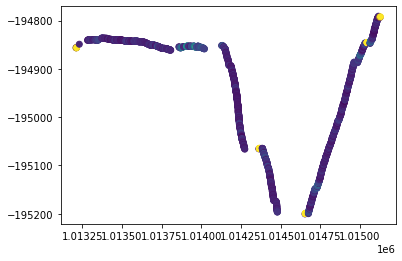

In [173]:
plt.scatter(mpeasting, mpnorthing, c = mpdata["DepthCm"])

Do the drift correction to local coordinates

In [174]:
local_mp_east = mpeasting - gnss_mp_match_eastings
local_mp_north = mpnorthing - gnss_mp_match_northings

Convert back to world coordinates

In [175]:
world_mp_east = local_mp_east + gnss_gem2_match_eastings[0]
world_mp_north = local_mp_north + gnss_gem2_match_northings[0]

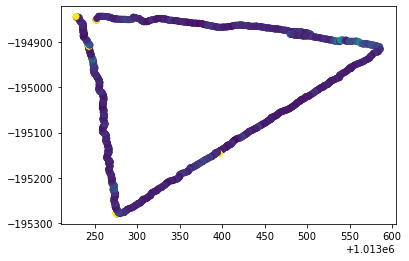

In [176]:
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"])

Export data to CSV

In [177]:
# first generate correct timestamps! Remembering the raw times are 1024 weeks out
mp_timefixed = []
i = 0
for thistime in mptimes:
    theday = datetime.strftime(mpdaysfixed[i],"%d-%m-%Y")
    thetimestamp = theday + "T" + thistime
    mp_timefixed.append(thetimestamp)
    i += 1

In [178]:
# Assemble a dataframe
mp_export = pd.DataFrame({"timestamp": mp_timefixed, 
                          "easting": world_mp_east, 
                          "northing": world_mp_north, 
                          "snowdepth": mpdata["DepthCm"]/100   })

In [179]:
mp_output = "/mnt/documents/Q1/P5-12032021/magnaprobe/MPdata-driftcorrected-datefixed.csv"

In [184]:
mp_header = """AeN Q1 2021 P5 Magnaprobe measurements
Snowhydro Magnaprobe NPI-1
12 March 2021
Adam Steer / Dmitry Divine
Date corrected: adding 1024 weeks to instrument timestamps to account for 2019 GPS week rollover
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for date and drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730

"""

In [185]:
with open(mp_output, 'w') as outfile:
    outfile.write(mp_header)
    

In [186]:
mp_export.to_csv(mp_output, index=False, mode='a')

## Plot GEM2 and magnaprobe data together

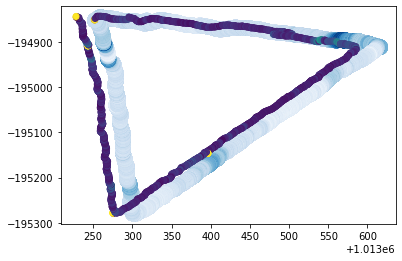

In [187]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200)
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100)